# Анализ бизнес-показателей

# Описание проекта

Вас пригласили на стажировку в отдел маркетинговой аналитики Яндекс.Афиши. Первое задание: помочь маркетологам снизить расходы — отказаться от невыгодных источников трафика и перераспределить бюджет.
Есть данные Яндекс.Афиши с июня 2017 по конец мая 2018 года:

лог сервера с данными о посещениях сайта Яндекс.Афиши,

выгрузка всех заказов за этот период,

статистика рекламных расходов.

Вам предстоит изучить:

как клиенты пользуются сервисом,

когда делают первые покупки на сайте,

сколько денег приносит компании каждый клиент,

когда расходы на привлечение клиента окупаются.
Выручка измеряется в условных единицах — у.е.

# Шаг 1. Загрузите данные и подготовьте их к анализу
1.1. Положите данные о визитах, заказах и рекламных расходах в переменные;

1.2. Подготовьте данные. 

Убедитесь, что тип данных во всех колонках соответствует сохранённым в них значениям.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as st

In [2]:
visits = pd.read_csv('/datasets/visits_log.csv')
orders = pd.read_csv('/datasets/orders_log.csv')
costs = pd.read_csv('/datasets/costs.csv')


In [3]:
visits.info()
orders.info()
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
Device       359400 non-null object
End Ts       359400 non-null object
Source Id    359400 non-null int64
Start Ts     359400 non-null object
Uid          359400 non-null uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
Buy Ts     50415 non-null object
Revenue    50415 non-null float64
Uid        50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null object
costs        2542 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


In [4]:
visits.columns = ['device', 'session_end_ts', 'source_id', 'session_start_ts', 'id']

In [5]:
visits.head()

,device,session_end_ts,source_id,session_start_ts,id
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


In [6]:
orders.columns = ['order_date', 'revenue', 'id']

In [7]:
orders.head()

,order_date,revenue,id
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


In [8]:
costs.head()

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


In [9]:
visits['session_end_ts'] = pd.to_datetime(visits['session_end_ts'], format="%Y-%m-%d %H:%M")
visits['session_start_ts'] = pd.to_datetime(visits['session_start_ts'], format="%Y-%m-%d %H:%M")
orders['order_date'] = pd.to_datetime(orders['order_date'])
costs['dt'] = pd.to_datetime(costs['dt'])

In [10]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
device              359400 non-null object
session_end_ts      359400 non-null datetime64[ns]
source_id           359400 non-null int64
session_start_ts    359400 non-null datetime64[ns]
id                  359400 non-null uint64
dtypes: datetime64[ns](2), int64(1), object(1), uint64(1)
memory usage: 13.7+ MB


Поменяли тип данных столбцов с датой с object на datetime, а также поменяли названия столбцов в таблицах, чтобы было удобнее ориентироваться.

# Шаг 2. Рассчитайте метрики и постройте графики

## 2.1. Продуктовые метрики

### 2.1.1. Рассчитайте DAU, WAU и MAU. Вычислите средние значения этих метрик за весь период

In [11]:
visits['session_year']  = visits['session_start_ts'].dt.year
visits['session_month'] = visits['session_start_ts'].dt.month
visits['session_week']  = visits['session_start_ts'].dt.week
visits['session_date'] = visits['session_start_ts'].dt.date
mau_total = visits.groupby(['session_year', 'session_month']).agg({'id': 'nunique'}).mean()
dau_total = visits.groupby('session_date').agg({'id': 'nunique'}).mean()
wau_total = visits.groupby(['session_year', 'session_week']).agg({'id': 'nunique'}).mean()
sticky_mau = dau_total / mau_total * 100
sticky_wau = dau_total / wau_total * 100
print('Среднее количество уникальных пользователей в день:', int(dau_total))
print('Среднее количество уникальных пользователей в неделю:', int(wau_total))
print('Среднее количество уникальных пользователей в месяц:', int(mau_total))
print('sticky factor WAU =', sticky_wau) 
print('sticky factor WAU =', sticky_mau) 

Среднее количество уникальных пользователей в день: 907
Среднее количество уникальных пользователей в неделю: 5716
Среднее количество уникальных пользователей в месяц: 23228
sticky factor WAU = id    15.884409
dtype: float64
sticky factor WAU = id    3.90897
dtype: float64


### 2.1.2. Определите, сколько раз за день пользователи в среднем заходят на сайт

In [12]:
sessions_per_user =visits.groupby('session_date').agg({'id': ['count','nunique']})
sessions_per_user.columns = ['n_sessions', 'n_users']
sessions_per_user['sessions_per_user'] = sessions_per_user['n_sessions'] / sessions_per_user['n_users']
print('Среднее количество сессий за день:', sessions_per_user['sessions_per_user'].mean()) 

Среднее количество сессий за день: 1.082169644003972


### 2.1.3. Исследуйте, сколько времени пользователи проводят на сайте.

0    60
dtype: int64


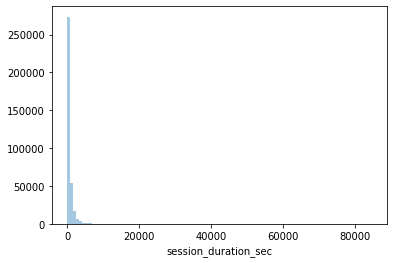

In [13]:
visits['session_duration_sec'] = (visits['session_end_ts'] - visits['session_start_ts']).dt.seconds
sns.distplot(visits['session_duration_sec'], kde=False, bins=100)
asl = visits['session_duration_sec'].mode()
print(asl)

Посчитали ASL как среднее от длины всех сессий, потом построили гистограмму. Так как у нас не нормальное распределение, то берем моду, а не среднее. Получили, что среднее время сессии - минута.

### 2.1.4. Рассчитайте Retention Rate, применяя когортный анализ. Найдите средний Retention Rate на второй месяц «жизни» когорт.

Будем работать с таблицей visits. Разделим пользователей на когорты в зависимости от их первого посещения сайта.

In [14]:
first_visit_date_by_customers = visits.groupby('id')['session_start_ts'].min()
first_visit_date_by_customers.name = 'first_visit_date'
visits = visits.merge(first_visit_date_by_customers, on='id', how='left')

In [15]:
visits['first_visit_month'] = visits['first_visit_date'].astype('datetime64[M]')
visits['visit_month'] = visits['session_date'].astype('datetime64[M]')

visits_grouped_by_cohorts = visits.groupby(['first_visit_month','visit_month']).agg({'id':'nunique'})


In [16]:
visits_grouped_by_cohorts.head(30)

id
first_visit_month visit_month       
2017-06-01        2017-06-01   13259
                  2017-07-01    1043
                  2017-08-01     713
                  2017-09-01     814
                  2017-10-01     909
                  2017-11-01     947
                  2017-12-01     809
                  2018-01-01     766
                  2018-02-01     694
                  2018-03-01     674
                  2018-04-01     539
                  2018-05-01     596
2017-07-01        2017-07-01   13140
                  2017-08-01     737
                  2017-09-01     674
                  2017-10-01     738
                  2017-11-01     765
                  2017-12-01     633
                  2018-01-01     596
                  2018-02-01     601
                  2018-03-01     510
                  2018-04-01     376
                  2018-05-01     361
2017-08-01        2017-08-01   10181
                  2017-09-01     783
                  2017-10-01     640
                  2017-11-01     639
                  2017-12-01     510
                  2018-01-01     448
                  2018-02-01     370

Получаем таблицу с распределением визитов на сайт по месяцам и когортам. Теперь посчитаем retention rate.

In [17]:
visits['cohort_lifetime'] = visits['visit_month'] - visits['first_visit_month']
visits['cohort_lifetime'] = visits['cohort_lifetime'] / np.timedelta64(1,'M')
visits['cohort_lifetime'] = visits['cohort_lifetime'].round().astype('int') 

In [18]:
cohorts = visits.groupby(['first_visit_month','cohort_lifetime']).agg({'id':'nunique'}).reset_index() 
initial_users_count = cohorts[cohorts['cohort_lifetime'] == 0][['first_visit_month','id']]
initial_users_count = initial_users_count.rename(columns={'id':'cohort_users'}) 
cohorts = cohorts.merge(initial_users_count,on='first_visit_month') 
cohorts['retention'] = cohorts['id']/cohorts['cohort_users'] 
retention_pivot = cohorts.pivot_table(index='first_visit_month',columns='cohort_lifetime',values='retention',aggfunc='sum') 
retention_pivot

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_visit_month,,,,,,,,,,,,
2017-06-01,1.0,0.078664,0.053775,0.061392,0.068557,0.071423,0.061015,0.057772,0.052342,0.050833,0.040652,0.044951
2017-07-01,1.0,0.056088,0.051294,0.056164,0.058219,0.048174,0.045358,0.045738,0.038813,0.028615,0.027473,NaN
2017-08-01,1.0,0.076908,0.062862,0.062764,0.050093,0.044004,0.036342,0.039485,0.027895,0.026029,NaN,NaN
2017-09-01,1.0,0.085489,0.069205,0.050706,0.039392,0.037835,0.035860,0.024186,0.022809,NaN,NaN,NaN
2017-10-01,1.0,0.078608,0.052239,0.038958,0.034261,0.032221,0.021365,0.020364,NaN,NaN,NaN,NaN
2017-11-01,1.0,0.078281,0.044113,0.038682,0.033727,0.023415,0.021800,NaN,NaN,NaN,NaN,NaN
2017-12-01,1.0,0.055802,0.037993,0.031107,0.020263,0.019036,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,1.0,0.059715,0.039339,0.024973,0.020244,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,1.0,0.057080,0.025454,0.020093,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Text(93.49999999999999, 0.5, 'Номер когорты')

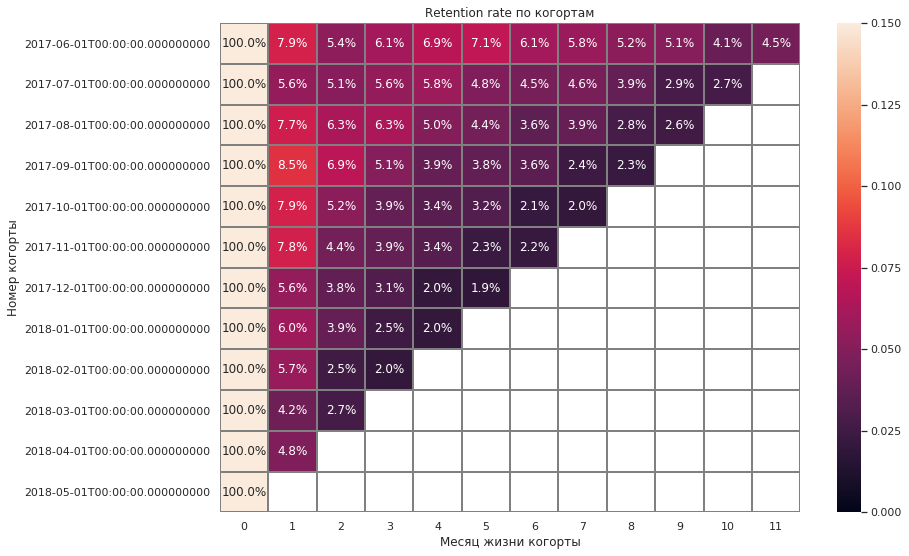

In [19]:
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Retention rate по когортам')

sns.heatmap(retention_pivot, vmin=0, vmax=0.15, annot=True, fmt='.1%', linewidths=1, linecolor='gray'); 
plt.xlabel('Месяц жизни когорты')
plt.ylabel('Номер когорты')

Получили heatmap для retention rate. Самый большой retention - у сентябрьской когорты.

In [20]:
cohorts[cohorts['cohort_lifetime'] == 1].groupby('cohort_lifetime')['retention'].mean()

cohort_lifetime
1    0.065167
Name: retention, dtype: float64

Средний retention для всех когорт на 2 месяц жизни составляет 6,5%.

В целом retention rate очень низкий, меньше 10%. У первой когорты - самые высокие значения этой метрики. Такой retention rate можно объяснить тем, что многие люди ходят в театр или на концерты нечасто. Поэтому и заходить каждый месяц на Афишу им не имеет смысла.

## 2.2. Метрики электронной коммерции

### 2.2.1. Исследуйте, сколько времени в среднем проходит с момента первого посещения сайта до совершения покупки. 

Посмотрим, сколько времени проходит с первого посещения до первой покупки. Теперь к таблице visits надо добавить таблицу orders.

In [21]:
first_orders = orders.groupby('id')['order_date'].min()
first_visit = visits[['id', 'first_visit_date']]
first_visit = first_visit.merge(first_orders, on='id', how='left').dropna().drop_duplicates()

In [22]:
first_visit['time_difference'] = first_visit['order_date'] - first_visit['first_visit_date']
first_visit['time_difference'] = first_visit['time_difference'] / np.timedelta64(1,'m')
first_visit['time_difference'] = first_visit['time_difference'].round(1)

In [23]:
first_visit

,id,first_visit_date,order_date,time_difference
3,16174680259334210214,2018-03-09 20:05:00,2018-03-09 20:25:00,20.0
5,16007536194108375387,2017-09-03 21:35:00,2017-09-04 12:46:00,911.0
12,8056418121947262981,2017-06-04 14:17:00,2017-06-25 08:54:00,29917.0
15,18188358787673499603,2018-02-10 12:17:00,2018-02-12 19:48:00,3331.0
25,2307401184189569202,2017-09-23 23:27:00,2017-09-27 09:23:00,4916.0
...,...,...,...,...
358438,6752020629696526518,2017-12-04 12:42:00,2017-12-04 12:46:00,4.0
358447,11750532881998794555,2017-11-20 23:33:00,2017-11-20 23:43:00,10.0
358484,11202626539189016002,2017-11-29 20:27:00,2017-11-29 20:33:00,6.0
358517,12734910664455613822,2018-04-23 21:11:00,2018-04-23 21:16:00,5.0


Построим графики.

In [24]:
to_hist = first_visit.groupby('id')[['time_difference']].min()

Text(0.5, 0, 'Разница во времени')

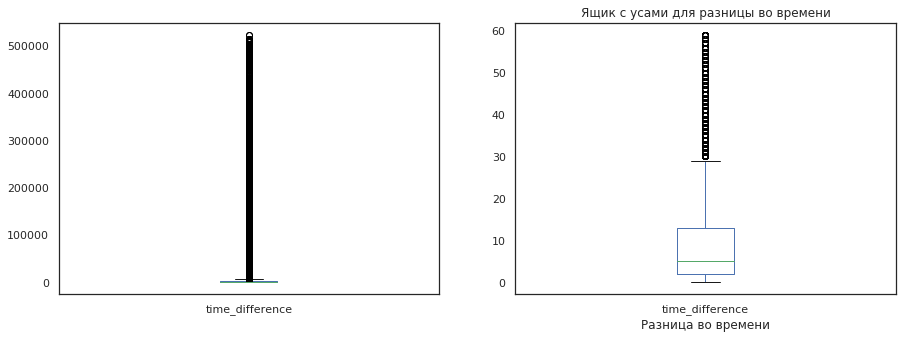

In [25]:
fig, axes = plt.subplots(1,2, figsize=(15,5))

to_hist.plot(kind='box', ax=axes[0])

to_hist.query('time_difference < 60').plot(kind='box', ax=axes[1])

plt.title('Ящик с усами для разницы во времени')
plt.xlabel('Разница во времени')

Выбросы начинаются с разницы по времени от 30 минут и более.

На основании этих данных построим гистограмму распределения этой разницы по времени:

Text(0.5, 0, 'Разница во времени')

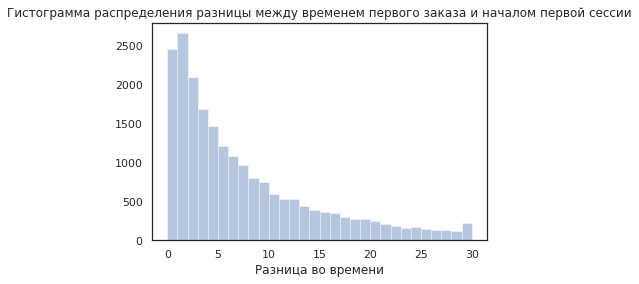

In [26]:
sns.distplot(to_hist.query('time_difference <= 30'), kde=False, bins=30)
plt.title('Гистограмма распределения разницы между временем первого заказа и началом первой сессии')
plt.xlabel('Разница во времени')

In [27]:
to_hist.median().values[0]

16.0

Медианная разница во времени между моментом совершения заказа и датой и временем первого визита - 16 минут.

Теперь посмотрим, как часто пользователи совершают покупки и на средний чек.

### 2.2.2. Применяя когортный анализ или другой метод, рассчитайте среднее количество покупок на одного покупателя за определённый период, например за 6 месяцев. 

In [28]:
orders = orders.merge(first_orders, on='id', how='left')

In [29]:
orders.columns = ['order_date', 'revenue', 'id', 'first_order_date']

In [30]:
orders['duration'] = orders['order_date'] - orders['first_order_date']
orders['duration'] = orders['duration'] / np.timedelta64(1,'M')
orders = orders.sort_values(by = 'duration', ascending = False)
less_orders = orders[orders['duration'] < 6]

In [31]:
count_orders = less_orders.groupby('id').agg({'order_date':'count'}).reset_index()
count_orders = count_orders.sort_values(by = 'order_date', ascending = False)
count_orders

,id,order_date
27482,13888745432979765063,160
13459,6731421022966725351,145
7206,3644482766749211722,132
20471,10343016064897450067,127
23600,11920452646463905188,121
...,...,...
13289,6639463736145804561,1
13288,6639158731782521409,1
13287,6639055814818614474,1
13286,6638652321977153945,1


In [32]:
count_orders['order_date'].mean()

1.3328039865290364

Получается, что в среднем один пользователь совершает за полгода чуть больше одной покупки. Скорее всего такое маленькое значение связано с небольшим retention rate: люди заходят на сайт, чтобы купить что-то одно, что им нужно и больше не возвращаются.

### 2.2.3. Рассчитайте средний чек

Теперь посчитаем средний чек.

In [33]:
orders['first_order_month'] = orders['first_order_date'].astype('datetime64[M]')
orders['order_month'] = orders['order_date'].astype('datetime64[M]')

orders_grouped_by_cohorts = orders.groupby(['first_order_month','order_month']).agg({'revenue':'sum','id':'nunique'})
orders_grouped_by_cohorts

revenue    id
first_order_month order_month                
2017-06-01        2017-06-01    9557.49  2023
                  2017-07-01     981.82    61
                  2017-08-01     885.34    50
                  2017-09-01    1931.30    54
                  2017-10-01    2068.58    88
...                                 ...   ...
2018-03-01        2018-05-01    1114.87    58
2018-04-01        2018-04-01   10600.69  2276
                  2018-05-01    1209.92    69
2018-05-01        2018-05-01   13925.76  2988
2018-06-01        2018-06-01       3.42     1

[79 rows x 2 columns]

In [34]:
orders_grouped_by_cohorts['revenue_per_user'] = orders_grouped_by_cohorts['revenue'] / orders_grouped_by_cohorts['id'] 

Для начала нам нужна таблица распределения выручки от одного покупателя относительно когорт.

In [35]:
orders_grouped_by_cohorts

revenue    id  revenue_per_user
first_order_month order_month                                  
2017-06-01        2017-06-01    9557.49  2023          4.724414
                  2017-07-01     981.82    61         16.095410
                  2017-08-01     885.34    50         17.706800
                  2017-09-01    1931.30    54         35.764815
                  2017-10-01    2068.58    88         23.506591
...                                 ...   ...               ...
2018-03-01        2018-05-01    1114.87    58         19.221897
2018-04-01        2018-04-01   10600.69  2276          4.657597
                  2018-05-01    1209.92    69         17.535072
2018-05-01        2018-05-01   13925.76  2988          4.660562
2018-06-01        2018-06-01       3.42     1          3.420000

[79 rows x 3 columns]

In [36]:
#средний чек
orders_grouped_by_cohorts_pivot = orders_grouped_by_cohorts.pivot_table(index='first_order_month',columns='order_month',values='revenue_per_user',aggfunc='mean') 

In [37]:
orders_grouped_by_cohorts_pivot

order_month,2017-06-01,2017-07-01,2017-08-01,2017-09-01,2017-10-01,2017-11-01,2017-12-01,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01,2018-06-01
first_order_month,,,,,,,,,,,,,
2017-06-01,4.724414,16.095410,17.706800,35.764815,23.506591,22.207761,31.011935,25.033191,19.295690,27.233556,25.681333,9.804151,NaN
2017-07-01,NaN,6.010218,12.396346,21.035965,10.786094,6.938163,7.896842,6.421111,6.992821,7.382143,12.861818,11.513846,NaN
2017-08-01,NaN,NaN,5.276518,11.148793,11.851321,12.182955,16.921250,12.139063,9.620333,12.610455,21.070000,8.307419,NaN
2017-09-01,NaN,NaN,NaN,5.644529,22.188385,13.445200,138.669189,19.881538,26.095000,27.437121,16.961351,11.044651,NaN
2017-10-01,NaN,NaN,NaN,NaN,5.003733,11.287427,6.753252,7.413152,7.072796,7.255139,6.573214,7.479701,NaN
2017-11-01,NaN,NaN,NaN,NaN,NaN,5.154683,7.339054,6.786583,12.510660,7.457284,4.580833,7.564839,NaN
2017-12-01,NaN,NaN,NaN,NaN,NaN,NaN,4.738191,7.816575,39.366019,48.135052,27.431400,23.518413,NaN
2018-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.135636,8.721228,12.365542,11.199767,4.699556,NaN
2018-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.156987,8.610000,4.942414,6.941026,NaN


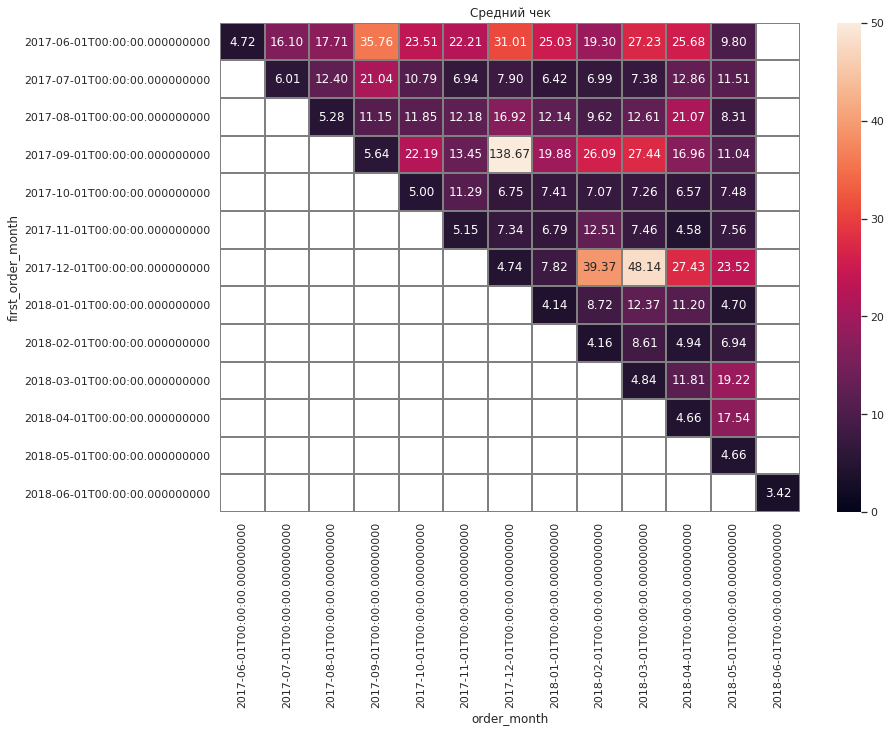

In [38]:
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Средний чек')
sns.heatmap(orders_grouped_by_cohorts_pivot, vmin=0, vmax=50, annot=True, fmt='.2f', linewidths=1, linecolor='gray');

Получили очень красочный heatmap среднего чека для когорт. У сентябрьской и декабрьской когорты он гораздо больше, чем у других.

### 2.2.4. Выясните, как меняется во времени LTV на покупателя по когортам.

Посчитаем LTV по когортам за 6 месяцев.

In [39]:
orders['order_month'] = orders['order_date'].astype('datetime64[M]')

first_orders = orders.groupby('id').agg({'order_month': 'min'}).reset_index()
first_orders.columns = ['id', 'first_order_month']

cohort_sizes = first_orders.groupby('first_order_month').agg({'id': 'nunique'}).reset_index()
cohort_sizes.columns = ['first_order_month', 'n_buyers']



In [40]:
margin_rate = 1

cohorts = orders.groupby(['first_order_month','order_month']).agg({'revenue': 'sum'}).reset_index()
report = pd.merge(cohort_sizes, cohorts, on='first_order_month')



In [41]:
report['gp'] =  report['revenue'] * margin_rate
report['age'] = (report['order_month'] - report['first_order_month']) / np.timedelta64(1, 'M')
report['age'] = report['age'].round().astype('int')
report['ltv'] = report['gp'] / report['n_buyers']
#report['ltv+'] = 
report_6_months = report[(report['first_order_month'] < '2017-12-01') & (report['age'] < 7)]

result = report_6_months.pivot_table(
        index='first_order_month', 
        columns='age', 
        values='ltv', 
        aggfunc='mean')


In [42]:
report[report['age'] == 0]

,first_order_month,n_buyers,order_month,revenue,gp,age,ltv
0,2017-06-01,2023,2017-06-01,9557.49,9557.49,0,4.724414
12,2017-07-01,1923,2017-07-01,11557.65,11557.65,0,6.010218
23,2017-08-01,1370,2017-08-01,7228.83,7228.83,0,5.276518
33,2017-09-01,2581,2017-09-01,14568.53,14568.53,0,5.644529
42,2017-10-01,4340,2017-10-01,21716.20,21716.20,0,5.003733
50,2017-11-01,4081,2017-11-01,21036.26,21036.26,0,5.154683
57,2017-12-01,4383,2017-12-01,20767.49,20767.49,0,4.738191
63,2018-01-01,3373,2018-01-01,13949.50,13949.50,0,4.135636
68,2018-02-01,3651,2018-02-01,15177.16,15177.16,0,4.156987
72,2018-03-01,3533,2018-03-01,17095.49,17095.49,0,4.838803


In [43]:
result

age,0,1,2,3,4,5,6
first_order_month,,,,,,,
2017-06-01,4.724414,0.485329,0.437637,0.954671,1.022531,0.735502,0.950440
2017-07-01,6.010218,0.335211,0.623531,0.358976,0.176791,0.156048,0.120208
2017-08-01,5.276518,0.471993,0.458482,0.391277,0.494051,0.283540,0.210664
2017-09-01,5.644529,1.117586,0.520930,3.975792,0.400558,0.647067,0.701608
2017-10-01,5.003733,0.535763,0.191394,0.157145,0.151560,0.120362,0.084816
2017-11-01,5.154683,0.399233,0.199556,0.324952,0.148013,0.053879,0.114928


In [44]:
report

,first_order_month,n_buyers,order_month,revenue,gp,age,ltv
0,2017-06-01,2023,2017-06-01,9557.49,9557.49,0,4.724414
1,2017-06-01,2023,2017-07-01,981.82,981.82,1,0.485329
2,2017-06-01,2023,2017-08-01,885.34,885.34,2,0.437637
3,2017-06-01,2023,2017-09-01,1931.30,1931.30,3,0.954671
4,2017-06-01,2023,2017-10-01,2068.58,2068.58,4,1.022531
...,...,...,...,...,...,...,...
74,2018-03-01,3533,2018-05-01,1114.87,1114.87,2,0.315559
75,2018-04-01,2276,2018-04-01,10600.69,10600.69,0,4.657597
76,2018-04-01,2276,2018-05-01,1209.92,1209.92,1,0.531599
77,2018-05-01,2988,2018-05-01,13925.76,13925.76,0,4.660562


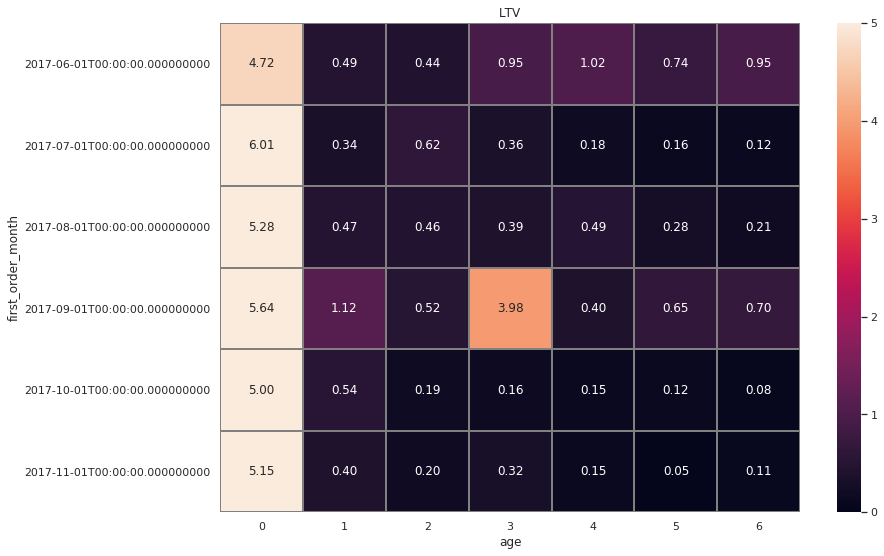

In [45]:
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('LTV')
sns.heatmap(result, vmin=0, vmax=5, annot=True, fmt='.2f', linewidths=1, linecolor='gray');

После первого месяца жизни когорт LTV резко падает. Значение 3.98 для сентябрьской когорты это какая-то аномалия.

Теперь почситаем суммарный LTV для каждой когорты за 6 месяцев.

In [46]:
print(result.loc['2017-06-01'].sum(),
     result.loc['2017-07-01'].sum(),
     result.loc['2017-08-01'].sum(),
     result.loc['2017-09-01'].sum(),
     result.loc['2017-10-01'].sum())


9.310523974295581 7.780982839313564 7.586525547445244 13.008070515304151 6.244771889400894


In [47]:
report_ltv = report.pivot_table(index = 'first_order_month', columns = 'age', values = 'ltv')
report_ltv

age,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,4.724414,0.485329,0.437637,0.954671,1.022531,0.735502,0.950440,0.581592,0.553213,0.605788,0.571261,0.256856
2017-07-01,6.010218,0.335211,0.623531,0.358976,0.176791,0.156048,0.120208,0.141820,0.161232,0.147145,0.155673,NaN
2017-08-01,5.276518,0.471993,0.458482,0.391277,0.494051,0.283540,0.210664,0.405007,0.292212,0.187978,NaN,NaN
2017-09-01,5.644529,1.117586,0.520930,3.975792,0.400558,0.647067,0.701608,0.243150,0.184006,NaN,NaN,NaN
2017-10-01,5.003733,0.535763,0.191394,0.157145,0.151560,0.120362,0.084816,0.115470,NaN,NaN,NaN,NaN
2017-11-01,5.154683,0.399233,0.199556,0.324952,0.148013,0.053879,0.114928,NaN,NaN,NaN,NaN,NaN
2017-12-01,4.738191,0.260374,0.925097,1.065275,0.312930,0.338047,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,4.135636,0.294758,0.304281,0.142778,0.062698,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,4.156987,0.278274,0.078515,0.074144,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [48]:
i = 0
for i in range(6):
    result.loc[:,i+1] += result.loc[:,i]
    i +=1
result

age,0,1,2,3,4,5,6
first_order_month,,,,,,,
2017-06-01,4.724414,5.209743,5.647380,6.602051,7.624582,8.360084,9.310524
2017-07-01,6.010218,6.345429,6.968960,7.327936,7.504727,7.660775,7.780983
2017-08-01,5.276518,5.748511,6.206993,6.598270,7.092321,7.375861,7.586526
2017-09-01,5.644529,6.762115,7.283045,11.258838,11.659396,12.306463,13.008071
2017-10-01,5.003733,5.539495,5.730889,5.888035,6.039594,6.159956,6.244772
2017-11-01,5.154683,5.553916,5.753472,6.078424,6.226437,6.280316,6.395244


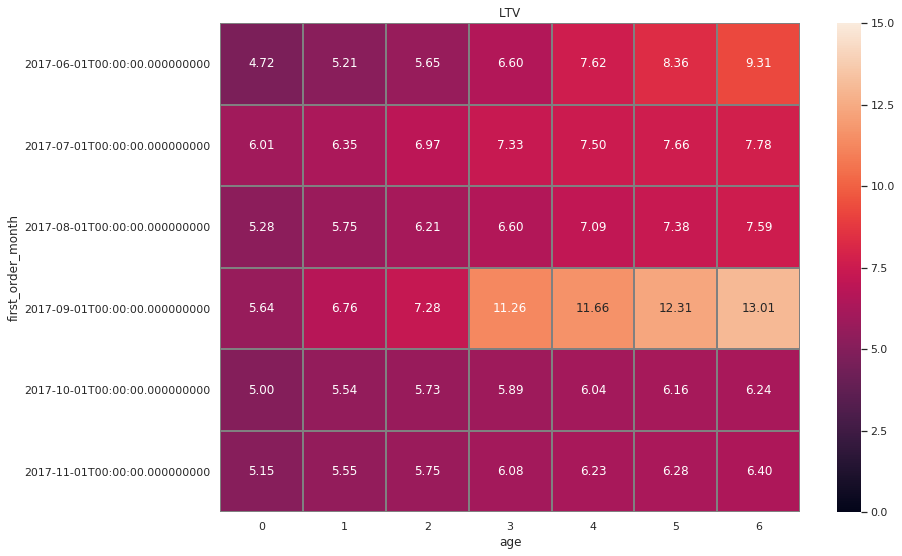

In [49]:
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('LTV')
sns.heatmap(result, vmin=0, vmax=15, annot=True, fmt='.2f', linewidths=1, linecolor='gray');

In [50]:
i = 0
for i in range(11):
    report_ltv.loc[:,i+1] += report_ltv.loc[:,i]
    i +=1
report_ltv

age,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,4.724414,5.209743,5.647380,6.602051,7.624582,8.360084,9.310524,9.892116,10.445329,11.051117,11.622378,11.879234
2017-07-01,6.010218,6.345429,6.968960,7.327936,7.504727,7.660775,7.780983,7.922803,8.084035,8.231180,8.386854,NaN
2017-08-01,5.276518,5.748511,6.206993,6.598270,7.092321,7.375861,7.586526,7.991533,8.283745,8.471723,NaN,NaN
2017-09-01,5.644529,6.762115,7.283045,11.258838,11.659396,12.306463,13.008071,13.251220,13.435227,NaN,NaN,NaN
2017-10-01,5.003733,5.539495,5.730889,5.888035,6.039594,6.159956,6.244772,6.360242,NaN,NaN,NaN,NaN
2017-11-01,5.154683,5.553916,5.753472,6.078424,6.226437,6.280316,6.395244,NaN,NaN,NaN,NaN,NaN
2017-12-01,4.738191,4.998565,5.923662,6.988937,7.301866,7.639913,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,4.135636,4.430394,4.734675,4.877453,4.940151,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,4.156987,4.435262,4.513777,4.587921,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


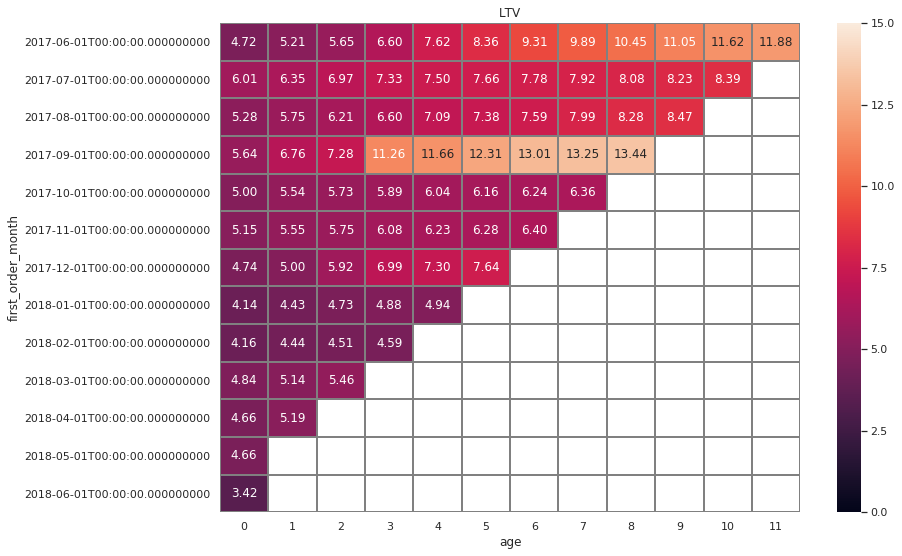

In [51]:
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('LTV')
sns.heatmap(report_ltv, vmin=0, vmax=15, annot=True, fmt='.2f', linewidths=1, linecolor='gray');

## 2.3. Маркетинговые метрики

### 2.3.1. Посчитайте общую сумму расходов на маркетинг. Выясните, как траты распределены по источникам

In [52]:
#распределение расходов по источникам
print(costs.groupby('source_id')['costs'].sum())
print('Общий маркетинговый бюджет', costs['costs'].sum())


source_id
1      20833.27
2      42806.04
3     141321.63
4      61073.60
5      51757.10
9       5517.49
10      5822.49
Name: costs, dtype: float64
Общий маркетинговый бюджет 329131.62


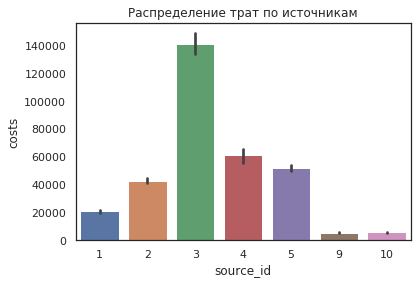

In [53]:
plt.title('Распределение трат по источникам')
sns.barplot(x='source_id', y='costs', data=costs, estimator=sum)

Видим, что наибольшие затраты приходятся на источник 3.

### 2.3.2. Рассчитайте средний CAC на одного покупателя для всего проекта и для каждого источника трафика

Средний САС на одного покупателя для всего проекта несложно: нужно просто поделить все затраты на всех покупателей.

In [54]:
all_buyers = orders['id'].nunique()
all_costs = costs['costs'].sum()
all_cac = all_costs / all_buyers
print('Cредний сас на одного покупателя для всего проекта:', all_cac)

Cредний сас на одного покупателя для всего проекта: 9.011626098622786


Теперь посчитаем САС для каждого источника трафика.

In [55]:
# покупатели по каналам
visits_sorted = visits.sort_values(by='session_start_ts')

# затраты по каналам
costs_per_source = costs.groupby('source_id').agg({'costs': 'sum'})

# выручка по каналам
first_source_per_user = visits_sorted.groupby('id').agg({'source_id': 'first'})
client_per_source = orders.merge(first_source_per_user, on='id')
client_per_source = client_per_source.groupby('source_id').agg({'id': 'nunique'})

# уникальные пользователи по каналам
uid_per_source = visits_sorted.groupby('source_id').agg({'id': 'nunique'})



In [56]:
rev_per_source = orders.merge(first_source_per_user, on='id')
rev_per_source = rev_per_source.groupby('source_id').agg({'revenue': 'sum'})



In [57]:
rev_uid_costs_per_source = pd.concat([costs_per_source, rev_per_source, 
                                      uid_per_source, client_per_source],axis=1).fillna(0)
rev_uid_costs_per_source = rev_uid_costs_per_source.reset_index()


In [58]:
rev_uid_costs_per_source

,source_id,costs,revenue,id,id
0,1,20833.27,31090.55,18999,2899.0
1,2,42806.04,46923.61,26245,3506.0
2,3,141321.63,54511.24,74756,10473.0
3,4,61073.60,56696.83,83525,10296.0
4,5,51757.10,52624.02,56974,6931.0
5,6,0.00,0.00,6,0.0
6,7,0.00,1.22,34,1.0
7,9,5517.49,5759.40,9264,1088.0
8,10,5822.49,4450.33,8067,1329.0


In [59]:
rev_uid_costs_per_source.columns = ['source_id', 'costs', 'revenue', 'unique_visitors', 'unique_buyers']

In [60]:
rev_uid_costs_per_source['unique_buyers'] = rev_uid_costs_per_source['unique_buyers'].astype('int')

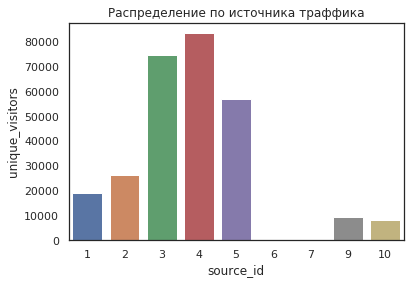

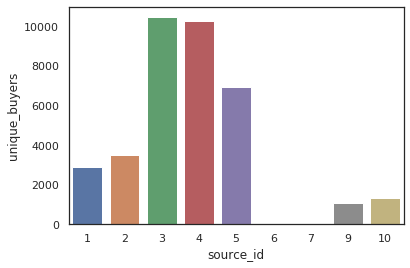

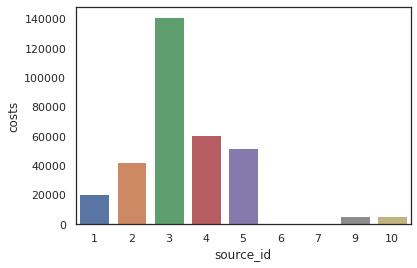

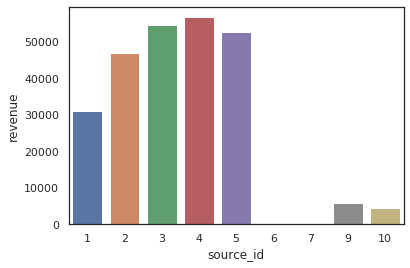

In [61]:
graphic = ['unique_visitors', 'unique_buyers', 'costs', 'revenue']
plt.title('Распределение по источника траффика')
for i in graphic:
    sns.barplot(x='source_id', y=i, data=rev_uid_costs_per_source)
    plt.show()

Теперь посчитаем CAC, как отношение затрат к количеству уникальных покупателей.

In [62]:
rev_uid_costs_per_source['price_for_client'] = rev_uid_costs_per_source['costs']/rev_uid_costs_per_source['unique_buyers']
rev_uid_costs_per_source['price_for_client'] = rev_uid_costs_per_source['price_for_client'].round(2)
cac_per_source = rev_uid_costs_per_source[['source_id', 'price_for_client']]


In [63]:
rev_uid_costs_per_source

,source_id,costs,revenue,unique_visitors,unique_buyers,price_for_client
0,1,20833.27,31090.55,18999,2899,7.19
1,2,42806.04,46923.61,26245,3506,12.21
2,3,141321.63,54511.24,74756,10473,13.49
3,4,61073.60,56696.83,83525,10296,5.93
4,5,51757.10,52624.02,56974,6931,7.47
5,6,0.00,0.00,6,0,NaN
6,7,0.00,1.22,34,1,0.00
7,9,5517.49,5759.40,9264,1088,5.07
8,10,5822.49,4450.33,8067,1329,4.38


In [64]:
cac_per_source

,source_id,price_for_client
0,1,7.19
1,2,12.21
2,3,13.49
3,4,5.93
4,5,7.47
5,6,NaN
6,7,0.00
7,9,5.07
8,10,4.38


САС для 2 и 3 источника наибольший. Это значит, что через эти каналы приходит мало пользователей, а траты на них - большие.

Посчитаем еще LTV и ROMI.

In [65]:
rev_uid_costs_per_source['ltv'] = rev_uid_costs_per_source['revenue']/rev_uid_costs_per_source['unique_buyers']
rev_uid_costs_per_source['cac'] = rev_uid_costs_per_source['costs']/rev_uid_costs_per_source['unique_buyers']
rev_uid_costs_per_source['romi'] = rev_uid_costs_per_source['ltv']/rev_uid_costs_per_source['cac']

In [66]:
rev_uid_costs_per_source

,source_id,costs,revenue,unique_visitors,unique_buyers,price_for_client,ltv,cac,romi
0,1,20833.27,31090.55,18999,2899,7.19,10.724577,7.186364,1.492351
1,2,42806.04,46923.61,26245,3506,12.21,13.383802,12.209367,1.096191
2,3,141321.63,54511.24,74756,10473,13.49,5.204931,13.493901,0.385725
3,4,61073.60,56696.83,83525,10296,5.93,5.506685,5.931779,0.928336
4,5,51757.10,52624.02,56974,6931,7.47,7.592558,7.467479,1.016750
5,6,0.00,0.00,6,0,NaN,NaN,NaN,NaN
6,7,0.00,1.22,34,1,0.00,1.220000,0.000000,inf
7,9,5517.49,5759.40,9264,1088,5.07,5.293566,5.071222,1.043844
8,10,5822.49,4450.33,8067,1329,4.38,3.348631,4.381106,0.764335


Наиболее перспективные источники трафика - 1 и 2. У них самая большая прибыль с пользователя. На 3 источник надо тратить меньше денег, потому что прибыль с него не оправдывает вложенных средств. 3 источник больше всех работает в убыток.

### 2.3.3. Рассчитайте ROMI по когортам в разрезе источников. Сравните окупаемость за одинаковые периоды жизни когорт.

Начинаем заниматься объединением и группировкой талиц, чтобы в итоге получить одну таблицу именно с теми данными, которые необходимы для расчета ROMI.

In [67]:
cohorts_sources = visits.groupby(['first_visit_month','source_id']).agg({'id':'nunique'}) #когорты в разрезе источников

In [68]:
visits_visits = visits[['id', 'source_id']]
orders_orders = orders[['id', 'first_order_month', 'revenue', 'order_month']] 
costs

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08
...,...,...,...
2537,10,2018-05-27,9.92
2538,10,2018-05-28,21.26
2539,10,2018-05-29,11.32
2540,10,2018-05-30,33.15


In [69]:


visits_orders = orders.merge(first_source_per_user, on='id').drop_duplicates()
visits_orders = visits_orders.sort_values(by='first_order_month')


In [70]:
first_source_per_user

,source_id
id,
11863502262781,3
49537067089222,2
297729379853735,3
313578113262317,2
325320750514679,5
...,...
18446403737806311543,5
18446424184725333426,4
18446556406699109058,3


In [71]:
visits_orders

,order_date,revenue,id,first_order_date,duration,first_order_month,order_month,source_id
0,2018-05-31 13:32:00,4.89,16674220541096562302,2017-06-01 17:33:00,11.953679,2017-06-01,2018-05-01,1
17287,2017-06-27 21:45:00,4.89,5469631501581780181,2017-06-27 21:45:00,0.000000,2017-06-01,2017-06-01,2
17286,2017-06-28 09:32:00,4.89,5469631501581780181,2017-06-27 21:45:00,0.016131,2017-06-01,2017-06-01,2
17259,2017-06-25 22:47:00,3.67,9799994546800469771,2017-06-25 22:47:00,0.000000,2017-06-01,2017-06-01,1
17258,2017-06-26 10:58:00,3.67,9799994546800469771,2017-06-25 22:47:00,0.016678,2017-06-01,2017-06-01,1
...,...,...,...,...,...,...,...,...
24115,2018-05-31 12:32:00,6.60,8854493451884066030,2018-05-31 12:32:00,0.000000,2018-05-01,2018-05-01,3
24114,2018-05-31 12:30:00,8.80,5893716492956700992,2018-05-31 12:30:00,0.000000,2018-05-01,2018-05-01,2
24113,2018-05-31 12:30:00,7.33,6274298010547617444,2018-05-31 12:30:00,0.000000,2018-05-01,2018-05-01,3
24059,2018-05-31 11:52:00,6.97,6209148945161911682,2018-05-31 11:52:00,0.000000,2018-05-01,2018-05-01,3


In [72]:
visits_orders['age'] = (visits_orders['order_month'] - visits_orders['first_order_month']) / np.timedelta64(1, 'M')
visits_orders['age'] = visits_orders['age'].round().astype('int')
visits_orders = visits_orders[(visits_orders['first_order_month'] < '2017-12-01') & (visits_orders['age'] < 7)]

Как раз на этом этапе оставим только данные за 6 месяцев и только для тех когорт, которые прожили 6 месяцев.

In [73]:
cohorts_visits_orders = visits_orders.groupby(['first_order_month','source_id']).agg({'revenue':'sum'})

Получаем таблицу когорт в разрезе источников трафика. Отсталось еще добавить затраты и количество пользователей.

In [74]:
cohorts_visits_orders.head(50)

revenue
first_order_month source_id          
2017-06-01        1           4618.37
                  2           2659.65
                  3           3517.16
                  4           3916.33
                  5           3469.97
                  9            413.30
                  10           240.41
2017-07-01        1           2795.88
                  2           2182.67
                  3           3600.96
                  4           3135.50
                  5           2726.40
                  9            335.67
                  10           185.75
2017-08-01        1           1474.82
                  2            959.88
                  3           1989.69
                  4           2051.65
                  5           3385.41
                  7              1.22
                  9            329.60
                  10           201.27
2017-09-01        1           2160.98
                  2           5612.78
                  3           5227.43
                  4           4360.41
                  5          15284.36
                  9            704.23
                  10           223.64
2017-10-01        1           2741.02
                  2           4853.11
                  3           6505.00
                  4           5949.47
                  5           5586.32
                  9            882.78
                  10           584.61
2017-11-01        1           3295.77
                  2           3868.50
                  3           6067.78
                  4           7951.94
                  5           3607.99
                  9            656.32
                  10           650.69

In [75]:
cohorts_visits_orders.pivot_table(index = 'first_order_month', columns = 'source_id', values = 'revenue', aggfunc = 'sum')

source_id,1,2,3,4,5,7,9,10
first_order_month,,,,,,,,
2017-06-01,4618.37,2659.65,3517.16,3916.33,3469.97,NaN,413.30,240.41
2017-07-01,2795.88,2182.67,3600.96,3135.50,2726.40,NaN,335.67,185.75
2017-08-01,1474.82,959.88,1989.69,2051.65,3385.41,1.22,329.60,201.27
2017-09-01,2160.98,5612.78,5227.43,4360.41,15284.36,NaN,704.23,223.64
2017-10-01,2741.02,4853.11,6505.00,5949.47,5586.32,NaN,882.78,584.61
2017-11-01,3295.77,3868.50,6067.78,7951.94,3607.99,NaN,656.32,650.69


In [76]:
costs['month'] = costs['dt'].astype('datetime64[M]')
costs_costs = costs[['month', 'costs', 'source_id']]
costs_costs.columns = ['first_order_month', 'costs', 'source_id']
costs_costs = costs_costs.groupby(['first_order_month', 'source_id']).agg({'costs':'sum'})

In [77]:
report2 = cohorts_visits_orders.merge(costs_costs, on= ['first_order_month', 'source_id']).drop_duplicates()
report2

revenue     costs
first_order_month source_id                    
2017-06-01        1           4618.37   1125.61
                  2           2659.65   2427.38
                  3           3517.16   7731.65
                  4           3916.33   3514.80
                  5           3469.97   2616.12
                  9            413.30    285.22
                  10           240.41    314.22
2017-07-01        1           2795.88   1072.88
                  2           2182.67   2333.11
                  3           3600.96   7674.37
                  4           3135.50   3529.73
                  5           2726.40   2998.14
                  9            335.67    302.54
                  10           185.75    329.82
2017-08-01        1           1474.82    951.81
                  2            959.88   1811.05
                  3           1989.69   6143.54
                  4           2051.65   3217.36
                  5           3385.41   2185.28
                  9            329.60    248.93
                  10           201.27    232.57
2017-09-01        1           2160.98   1502.01
                  2           5612.78   2985.66
                  3           5227.43   9963.55
                  4           4360.41   5192.26
                  5          15284.36   3849.14
                  9            704.23    415.62
                  10           223.64    460.67
2017-10-01        1           2741.02   2315.75
                  2           4853.11   4845.00
                  3           6505.00  15737.24
                  4           5949.47   6420.84
                  5           5586.32   5767.40
                  9            882.78    609.41
                  10           584.61    627.24
2017-11-01        1           3295.77   2445.16
                  2           3868.50   5247.68
                  3           6067.78  17025.34
                  4           7951.94   5388.82
                  5           3607.99   6325.34
                  9            656.32    683.18
                  10           650.69    792.36

In [78]:
client_per_source2 = orders.merge(first_source_per_user, on='id')
client_per_source2 = client_per_source2.groupby(['first_order_month', 'source_id']).agg({'id': 'nunique'})

In [79]:
report2 = report2.merge(client_per_source2, on= ['first_order_month', 'source_id']).drop_duplicates()

Таблица в сборе, теперь можно посчитать Romi.

In [80]:
report2['ltv'] = report2['revenue']/report2['id']
report2['cac'] = report2['costs']/report2['id']
report2['romi'] = report2['ltv']/report2['cac']
result2 = report2.pivot_table(index = 'first_order_month', columns='source_id', values='romi')


In [81]:
report2

revenue     costs    id        ltv        cac  \
first_order_month source_id                                                   
2017-06-01        1           4618.37   1125.61   190  24.307211   5.924263   
                  2           2659.65   2427.38   235  11.317660  10.329277   
                  3           3517.16   7731.65   638   5.512790  12.118574   
                  4           3916.33   3514.80   413   9.482639   8.510412   
                  5           3469.97   2616.12   384   9.036380   6.812813   
                  9            413.30    285.22    68   6.077941   4.194412   
                  10           240.41    314.22    95   2.530632   3.307579   
2017-07-01        1           2795.88   1072.88   160  17.474250   6.705500   
                  2           2182.67   2333.11   208  10.493606  11.216875   
                  3           3600.96   7674.37   512   7.033125  14.989004   
                  4           3135.50   3529.73   517   6.064797   6.827331   
                  5           2726.40   2998.14   423   6.445390   7.087801   
                  9            335.67    302.54    52   6.455192   5.818077   
                  10           185.75    329.82    51   3.642157   6.467059   
2017-08-01        1           1474.82    951.81   113  13.051504   8.423097   
                  2            959.88   1811.05   123   7.803902  14.723984   
                  3           1989.69   6143.54   337   5.904125  18.230089   
                  4           2051.65   3217.36   338   6.069970   9.518817   
                  5           3385.41   2185.28   360   9.403917   6.070222   
                  9            329.60    248.93    61   5.403279   4.080820   
                  10           201.27    232.57    37   5.439730   6.285676   
2017-09-01        1           2160.98   1502.01   227   9.519736   6.616784   
                  2           5612.78   2985.66   221  25.397195  13.509774   
                  3           5227.43   9963.55   781   6.693252  12.757426   
                  4           4360.41   5192.26   590   7.390525   8.800441   
                  5          15284.36   3849.14   589  25.949677   6.535042   
                  9            704.23    415.62    87   8.094598   4.777241   
                  10           223.64    460.67    86   2.600465   5.356628   
2017-10-01        1           2741.02   2315.75   340   8.061824   6.811029   
                  2           4853.11   4845.00   396  12.255328  12.234848   
                  3           6505.00  15737.24  1152   5.646701  13.660799   
                  4           5949.47   6420.84  1172   5.076340   5.478532   
                  5           5586.32   5767.40   945   5.911450   6.103069   
                  9            882.78    609.41   126   7.006190   4.836587   
                  10           584.61    627.24   209   2.797177   3.001148   
2017-11-01        1           3295.77   2445.16   324  10.172130   7.546790   
                  2           3868.50   5247.68   398   9.719849  13.185126   
                  3           6067.78  17025.34  1216   4.989951  14.001102   
                  4           7951.94   5388.82  1177   6.756109   4.578437   
                  5           3607.99   6325.34   693   5.206335   9.127475   
                  9            656.32    683.18   145   4.526345   4.711586   
                  10           650.69    792.36   128   5.083516   6.190313   

                                 romi  
first_order_month source_id            
2017-06-01        1          4.102993  
                  2          1.095688  
                  3          0.454904  
                  4          1.114240  
                  5          1.326380  
                  9          1.449057  
                  10         0.765101  
2017-07-01        1          2.605958  
                  2          0.935520  
                  3          0.469219  
                  4          0.888312  
                  5          0.90

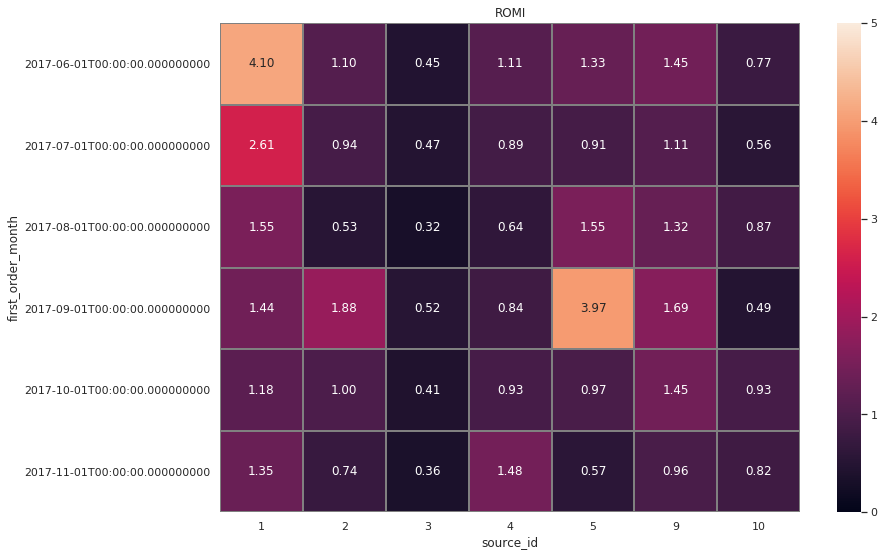

In [82]:
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('ROMI')
sns.heatmap(result2, vmin=0, vmax=5, annot=True, fmt='.2f', linewidths=1, linecolor='gray');

В очередной раз обратим внимание на сентябрьскую когорту, как на аномально прибыльную. По нашей тепловой карте видно, что самый убыточный источник трафика это 3.

# Шаг 3. Сформулируйте выводы и рекомендации

## 3.1. Определите источники трафика, на которые маркетологам стоит делать упор. Объясните свой выбор: на какие метрики вы ориентируетесь и почему

Во-первых, я бы посоветовал обратить внимание на 6 и 7 источники трафика. Даже при отсутствии всяких затрат на них у нас были переходы с них и даже одна покупка.
Во-вторых, обратите внимание на 1 и 9 источники. У них по когортам за полгода самое большое ROMI.

## 3.2. Опишите выводы, которые вы сделали после подсчёта метрик каждого вида: маркетинговых, продуктовых и метрик электронной коммерции;

У сайта очень низкий retention rate. Пользователи проводят на сайте в среднем около минуты. Это значит, что люди заходят и после пары кликов уходят. После первой покупки очень мало людей возвращается и в среднем люди делают 1-2 покупки в месяц. Выделяется июньская когорта - у нее удивительно большой retention в сравнении с другими когортами. 

В среднем людям требуется 16 минут, чтобы оформить заказ. Средний чек у всех когорт редко превышает 10 у.е. Исключение составляют июньская и сентябрьская когорта. У них средние чеки гораздо выше.

Покупатели, приходящие из 1 и 2 источника приносят наибольший revenue: у них самый высокий LTV.
В плане цена/качество, лучше всех себя проявляют 1 и 9 источники, у них наибольший ROMI.


## 3.3. Подведите итоги когортного анализа. Определите самые перспективные для компании когорты клиентов

Можно сделать общий вывод: retention rate и LTV становятся меньше с увеличением возраста когорты.
Лучше всего проявляет себя июньская когорта. У нее стабильно высокий retention и LTV. Наверное имеет смысл поработать с ними плотнее.

Еще я бы выделил сентябрьскую когорту.У них был аномально огромный средний чек за месяц. Может быть это была какая-то одна очень дорогая покупка, а может все представители когорты сразу решили раскошелиться. Поэтому необходимо обратить на эту когорту внимание.